<h1>SABR model machine learning</h1>
<p style='width: 1000px;'>This notebook demonstrates an example of using machine learning with the SABR volatility model. First, we read the options market data provided. Second, fit the SABR model parameters for each ticker by minimization of the mean squared error. Finally, we fit the machine learning models and test their predictions.</p>

In [35]:
# Common imports
import time, os
import pandas as pd
import numpy as np
root_dir = '/mnt/c/Users/Steve/implied_vol_machine_learning'

<h2>Read and process data</h2>
<p style='width: 1000px;'>We read the option data and filter out put options, bad data, negative maturities (required for SABR), and deep out-of-the-money options. Since deep out-of-the-money options will have near-zero values, more datapoints in that range will not provide more value to the model, will require longer to fit parameters, and may sometimes skew the results. I'm not very confident it is right to remove them, or that 2.5 is a reasonable cutoff, so please raise this point in future discussions if you have more to offer.</p>

In [2]:
import datetime as dt

raw_data = pd.read_csv(os.path.join(root_dir, 'options_20220824.csv'))

# For simplicity, let's only analyze call options
# Also clean out some bad data
call_data = raw_data.loc[(raw_data["Type"] == "call") & (raw_data["Ask"] < 99000.0)].copy()

# Add some columns
call_data.loc[:, "moneyness"] = call_data["Strike"] / call_data["UnderlyingPrice"]
call_data.loc[:, "implied_vol"] = call_data["IV"]
call_data.loc[:, "maturity"] = (pd.to_datetime(call_data["Expiration"]) - pd.to_datetime(call_data[" DataDate"])).dt.days / 365
call_data.loc[:, "ticker"] = call_data["UnderlyingSymbol"]
call_data.loc[:, "Mid"] = (call_data["Bid"]+call_data["Ask"])/2
print(f"Quote dates: {call_data[' DataDate'].unique()}")
print(f"Moneyness: min={call_data['moneyness'].min()}, max={call_data['moneyness'].max()}")
print(f"Maturity: min={call_data['maturity'].min()}, max={call_data['maturity'].max()}")

Quote dates: ['08/24/2022 16:00']
Moneyness: min=0.005609846402405502, max=8750.0
Maturity: min=-0.0027397260273972603, max=5.315068493150685


In [3]:
# Drop the columns we don't need
# Remove negative maturities and deep out of the money options
model_input_data = call_data.loc[(call_data["maturity"] > 0.0) & (call_data["moneyness"] <= 2.5), ["ticker", "moneyness", "maturity", "implied_vol"]].copy() # we don't need other columns for this exercise

<h2>Fit the model parameters</h2>
<p style='width: 1000px;'>Using scipy.optimize.minimize and a mean-squared error function on QuantLib.sabrVolatility, we fit the model parameters &alpha; &isin; (0,&infin;), &beta; &isin; (0,1], &nu; &isin; (0, &infin;), and &rho; &isin; (-1,1) for every ticker. Since this fitting was time-consuming, the parameter values are saved to file model_parameters_by_ticker.csv.</p>

In [ ]:
import QuantLib as ql
import numpy as np

# Create MSE function
def sabr_vol_mse(model_params, maturity, moneyness, implied_vol):
    alpha, beta, nu, rho = model_params
    val = np.array([ql.sabrVolatility(float(money), 1, float(mat), alpha, beta, nu, rho) for mat, money in zip(maturity, moneyness)]) - implied_vol
    return np.sqrt(val * val).sum()


In [35]:
import time
from scipy.optimize import minimize

alpha = 0.5; beta = 0.5; nu = 1.0; rho = 0.5
start_values = [alpha, beta, nu, rho]
bounds = [(0.0001, float('inf')), (0.0001, 1.0), (0.0001, float('inf')), (-0.9999, 0.9999)]

model_params_by_ticker = {}
error_tickers = []
start = time.time()
for ticker, ticker_data in model_input_data.groupby('ticker'):
    res = minimize(sabr_vol_mse, start_values, bounds=bounds, args=(ticker_data['maturity'], ticker_data['moneyness'], ticker_data['implied_vol']), tol=1e-3, method="Powell")
    if res.success:
        model_params_by_ticker[ticker] = res.x
    else:
        error_tickers.append(ticker)
end = time.time()

print(end-start)
print(error_tickers)
print(len(model_params_by_ticker))

1194.0928888320923
[]
5685


In [47]:
models = pd.DataFrame(model_params_by_ticker).T.rename(columns={0: 'Alpha', 1: 'Beta', 2: 'Nu', 3: 'Rho'})
print(models.iloc[0:3])

models.to_csv(os.path.join(root_dir, 'model_parameters_by_ticker.csv'))

         Alpha      Beta        Nu       Rho
A     0.314901  0.651984  0.766485 -0.427394
AA    0.617718  0.021392  0.474265  0.999899
AADI  1.028776  0.373621  0.734218  0.999900


<h2>Create volatilty surfaces</h2>
<p style='width: 1000px;'>Using the solved-for SABR parameters and the model function QuantLib.sabrVolatility, generate a volatility surface for each ticker to use as our target data for training and testing the machine learning model. An alternative to using the model would be to use the empirical data as the target in the machine learning model, but aspects of the assignment suggested that I should use the theoretical model values. Since it is of interest to me, I also provide a section in which I use empirical data. Perhaps that was the intent of the assignment, anyway. In the case of the emprical data, I will not use the whole volatility surface as the target, but instead the individual points, turning moneyness and maturity into parameters, joining &alpha;, &beta;, &nu;, and &rho; for a total of six input parameters.</p>

In [91]:
models = pd.read_csv(os.path.join(root_dir, 'model_parameters_by_ticker.csv')).rename(columns={'Unnamed: 0' : 'ticker'})
print(models.iloc[0:3])

moneyness_axis = np.linspace(0.001, 2.5, 10)
maturity_axis = np.linspace(0.001, 5.0, 10)
print(f'Moneyness axis: {moneyness_axis}')
print(f'Maturity axis: {maturity_axis}')
vol_surfaces = np.zeros((models.shape[0], len(moneyness_axis)*len(maturity_axis)))

for row_idx, row in models.iterrows():
    vol_surfaces[row_idx,:] = np.array([ql.sabrVolatility(float(money), 1, float(mat), row['Alpha'], row['Beta'], row['Nu'], row['Rho']) for mat in maturity_axis for money in moneyness_axis])

print(vol_surfaces[0:2,0:10])

  ticker     Alpha      Beta        Nu       Rho
0      A  0.314901  0.651984  0.766485 -0.427394
1     AA  0.617718  0.021392  0.474265  0.999899
2   AADI  1.028776  0.373621  0.734218  0.999900
Moneyness axis: [1.00000000e-03 2.78666667e-01 5.56333333e-01 8.34000000e-01
 1.11166667e+00 1.38933333e+00 1.66700000e+00 1.94466667e+00
 2.22233333e+00 2.50000000e+00]
Maturity axis: [1.00000000e-03 5.56444444e-01 1.11188889e+00 1.66733333e+00
 2.22277778e+00 2.77822222e+00 3.33366667e+00 3.88911111e+00
 4.44455556e+00 5.00000000e+00]
[[2.05734001 0.67870442 0.47705761 0.36024642 0.29476128 0.27800752
  0.28766479 0.30419387 0.32123448 0.33720025]
 [4.17547152 0.76343738 0.66528544 0.63025282 0.61102312 0.59792982
  0.58786711 0.57955642 0.57237815 0.56599448]]


In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    vol_surfaces, models.drop(columns=['ticker']).to_numpy(), test_size=0.15, random_state=42)
from sklearn.preprocessing import StandardScaler

# scale = StandardScaler()
scale2=  StandardScaler()
# y_train_transform = scale.fit_transform(y_train)
# y_test_transform = scale.transform(y_test)
x_train_transform = scale2.fit_transform(X_train)
x_test_transform = scale2.transform(X_test)

# Get upper and lower bounds from model data
# Rho probably didn't need transformation (already on (-1, 1)), but for uniformity of the code, I'll transform it
ub=[models[column].max() for column in models.drop(columns='ticker').columns]
lb=[models[column].min() for column in models.drop(columns='ticker').columns]
print(f'Upper bounds: {ub}') # these honestly look a little crazy - might need to look into that later
print(f'Lower bounds: {lb}') # likewise


# Create transformation/scaling functions
def myscale(x):
    res=np.zeros(len(ub))
    for i in range(len(ub)):
        res[i]=(x[i] - (ub[i] + lb[i])*0.5) * 2 / (ub[i] - lb[i]) 
    return res


def myinverse(x):
    res=np.zeros(len(ub))
    for i in range(len(ub)):
        res[i]=x[i]*(ub[i] - lb[i]) *0.5 + (ub[i] + lb[i])*0.5
    return res


def xtransform(X_train,X_test):
    return [scale2.transform(X_train),scale2.transform(X_test)] # this strikes me as a little strange (from a programming standpoint), but I can just do what they're doing for now


def xinversetransform(x):
    return scale2.inverse_transform(x)


# Apply scaling/transformation to data
[x_train_transform,x_test_transform]=xtransform(X_train,X_test)
y_train_transform = np.array([myscale(y) for y in y_train])
y_test_transform = np.array([myscale(y) for y in y_test])

Upper bounds: [3977.290955507308, 0.9999999999999925, 14835.60433962666, 0.9998999999981376]
Lower bounds: [0.000100000000336, 0.0001000000000014, 0.0001000003836251, -0.9998999999931324]


<h2>Neural network on theoretical data</h2>
<p style='width: 1000px;'>Using the methodology outlined by <a href='https://github.com/amuguruza/NN-StochVol-Calibrations/blob/master/Heston/NNHeston.ipynb'>Horvath, Muguruza, and Tomas</a>, re-scale the inputs to the keras neural network and fit the NN model, then test the predictions. Keras is used, instead of scikit, to keep in line with the paper's methodology. Additional areas of research for myself: more depth of knowledge and perhaps brute-force testing of different numbers of hidden layers in the neural network and other optimizers besides Adam (e.g. lbfgs or sgd). If this was intended to be a part of the exercise, I can revisit. I wouldn't say that there's a ton of value of trying to reproduce SABR's theoretical values as a neural network would, as QuantLib.sabrVolatility seems to perform quite well. It is unclear to me whether I have misinterpreted the intent of the exercise and I should have used empirical data, or if the exercise is indeed to simply show that I can set up and perform parameter fitting and a basic machine learning model. Regardless, the next section covers what it might look like to use empirical data as the target to the machine learning model.</p>
<p style='width: 1000px;'>As a side note, I have left in some of the original author's sometimes strange and inconsequential coding choices, as I have made very few other changes to their methodology</p>

In [129]:
import keras, time
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
keras.backend.set_floatx('float64')

input1 = keras.layers.Input(shape=(4,))
x1 = keras.layers.Dense(30,activation = 'elu')(input1)
x2=keras.layers.Dense(30,activation = 'elu')(x1) 
x3=keras.layers.Dense(30,activation = 'elu')(x2) 
x4=keras.layers.Dense(x_train_transform.shape[1],activation = 'linear')(x3)

modelGEN = keras.models.Model(inputs=input1, outputs=x4)
print(modelGEN.summary())

start = time.time()
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
modelGEN.compile(loss = root_mean_squared_error, optimizer = "adam")
modelGEN.fit(y_train_transform, x_train_transform, batch_size=32, validation_data = (y_test_transform, x_test_transform), epochs = 200, verbose = False, shuffle=1)#,callbacks=[earlystop])
end = time.time()

print(f'Time to fit: {end-start}s')

modelGEN.save_weights(os.path.join(root_dir, 'sabr_kera_nn.h5'))

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 4)]               0         
                                                                 
 dense_44 (Dense)            (None, 30)                150       
                                                                 
 dense_45 (Dense)            (None, 30)                930       
                                                                 
 dense_46 (Dense)            (None, 30)                930       
                                                                 
 dense_47 (Dense)            (None, 100)               3100      
                                                                 
Total params: 5,110
Trainable params: 5,110
Non-trainable params: 0
_________________________________________________________________
None
Time to fit: 61.4217267036438s


In [130]:
modelGEN.load_weights(os.path.join(root_dir, 'sabr_kera_nn.h5'))

predictions = modelGEN.predict(y_test_transform)
total_mse = root_mean_squared_error(predictions, x_test_transform)
print(f'Sum of errors: {total_mse}')
print(f'Average error: {total_mse/x_test_transform.shape[0]}')

27/27 [==============================] - 0s 1ms/step
Sum of errors: 0.0036128783456603896
Average error: 4.235496302063763e-06


<h2>Machine learning on empirical data</h2>
<p style='width: 1000px;'>Instead of using a theoretical volatility surface as the target, we fit the machine learning model to the empirical data provided. This may produce something that is only SABR-like as a model, but fit the empirical data more closely, almost as an independent model. In practice, this may provide much more value than a machine learning model on the theoretical values, but may not have been the intent of this exercise. Regardless, it was fun, so let's do it.</p>
<p style='width: 1000px;'>For lack of experience and a better resource <a href='https://www.educative.io/blog/scikit-learn-cheat-sheet-classification-regression-methods'>this author</a> provides a starting place for some models I can try. Since my target in this case is continuous (i.e. a float), I need to stick to the regression models. Linear models can be ruled out in this case, due to the non-linear nature of the problem.</p>
<p style='width: 1000px;'>After very limited experimentation, lightgbm with boosting_type='gbdt' seemed to perform the best, both in time and accuracy. Take that with a grain of salt - more robust timing tests and more sample data would be required, but may not be in the scope for this exercise.</p>

In [15]:
from sklearn.model_selection import train_test_split

# Join the data into one dataframe, then split into X and y numpy arrays for training and testing
models = pd.read_csv(os.path.join(root_dir, 'model_parameters_by_ticker.csv')).rename(columns={'Unnamed: 0' : 'ticker'})
full_table = model_input_data.merge(models, left_on='ticker', right_on='ticker')
print(full_table.iloc[0:3])

y = full_table['implied_vol'].to_numpy()
X = full_table[['Alpha', 'Beta', 'Nu', 'Rho', 'moneyness', 'maturity']].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2)

  ticker  moneyness  maturity  implied_vol     Alpha      Beta        Nu  \
0      A   0.448867  0.060274       0.3615  0.314901  0.651984  0.766485   
1      A   0.486272  0.060274       0.3615  0.314901  0.651984  0.766485   
2      A   0.523678  0.060274       0.3615  0.314901  0.651984  0.766485   

        Rho  
0 -0.427394  
1 -0.427394  
2 -0.427394  


In [ ]:
# Ruled out models

# Linear - will not represent our model well
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge

from sklearn.kernel_ridge import KernelRidge # huge memory requirement
from sklearn.svm import SVR # took way too long to fit

<h3>Neural network</h3>
<p style='width: 1000px;'>Revisiting neural networks for empirical data, we should have pretty decent non-linear representation of our model, but at a cost to time. For lack of my own depth of knowledge, I merely copied the hidden layer sizes from the previous example. More experimentation could be done in that area. Values are scaled as recommended by scikit's documentation. I read something in the documentation about how partial_fit can provide live updates. That sounds like a nice feature, depending on the context.</p>
<p>Since neural networks are so slow, this mostly served as a benchmark for how accurate the other models should be</p>

In [170]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  

scaler = StandardScaler()  
scaler.fit(X_train)  
NN_X_train = scaler.transform(X_train)  
NN_X_test = scaler.transform(X_test)  

start = time.time()
regr = MLPRegressor(hidden_layer_sizes=(30, 30, 30), random_state=3, max_iter=500).fit(NN_X_train, y_train)
end = time.time()
print(f'Time to train: {end-start}s')

Time to train: 185.36060881614685s


In [176]:
y_pred = regr.predict(NN_X_test)
diffs = np.absolute(y_pred - y_test)
print(f'Max diff: {diffs.max()}')
print(f'Mean diff: {diffs.mean()}')
print(f'Std of diffs: {diffs.std()}')

Max diff: 17.255765892710517
Mean diff: 0.11748781902633175
Std of diffs: 0.27588991671591356


<h3>LightGBM histogram-based boosted decision trees</h3>
<p style='width: 1000px;'>LightGBM's algorithm seemed to perform fairly well with the default parameters. Very, very fast and more accurate than the neural network.</p>
Basic parameters of interest:
<ul>    
    <li>boosting_type
        <ul>
           <li>gbdt - fastest and most accurate (based on limited tests)</li> 
           <li>dart - significantly slower</li> 
           <li>goss - about the same, but seemingly slightly worse than gbdt</li> 
           <li>rf - errored out; may revisit later</li> 
        </ul>
    </li>
    <li>num_leaves - doesn't seem to have much of an effect</li>
</ul>

<h4>boosting_type="gbdt"</h4>

In [22]:
from lightgbm import LGBMRegressor

start = time.time()
lgbm_reg = LGBMRegressor(random_state=4).fit(X_train, y_train)
end = time.time()
print(f'Time to train: {end-start}s')

Time to train: 1.0504469871520996s


In [23]:
y_pred = lgbm_reg.predict(X_test)
diffs = np.absolute(y_pred - y_test)
print(f'Max diff: {diffs.max()}')
print(f'Mean diff: {diffs.mean()}')
print(f'Std of diffs: {diffs.std()}')

Max diff: 16.2218124340518
Mean diff: 0.10211942758361592
Std of diffs: 0.25252817156831264


<h4>boosting_type="dart"</h4>

In [24]:
from lightgbm import LGBMRegressor

start = time.time()
lgbm_reg2 = LGBMRegressor(boosting_type="dart", random_state=4).fit(X_train, y_train)
end = time.time()
print(f'Time to train: {end-start}s')

Time to train: 4.92429518699646s


In [25]:
y_pred = lgbm_reg2.predict(X_test)
diffs = np.absolute(y_pred - y_test)
print(f'Max diff: {diffs.max()}')
print(f'Mean diff: {diffs.mean()}')
print(f'Std of diffs: {diffs.std()}')

Max diff: 17.274780418407648
Mean diff: 0.11956121455845019
Std of diffs: 0.2886472940217107


<h4>boosting_type="goss"</h4>

In [26]:
from lightgbm import LGBMRegressor

start = time.time()
lgbm_reg3 = LGBMRegressor(boosting_type="goss", random_state=4).fit(X_train, y_train)
end = time.time()
print(f'Time to train: {end-start}s')

Time to train: 1.5653154850006104s


In [27]:
y_pred = lgbm_reg2.predict(X_test)
diffs = np.absolute(y_pred - y_test)
print(f'Max diff: {diffs.max()}')
print(f'Mean diff: {diffs.mean()}')
print(f'Std of diffs: {diffs.std()}')

Max diff: 17.274780418407648
Mean diff: 0.11956121455845019
Std of diffs: 0.2886472940217107


<h4>num_leaves</h4>

In [47]:
num_leaves_arr = np.linspace(5, 60, 12).astype('int')
print(num_leaves_arr)

time_arr = np.zeros(len(num_leaves_arr))
mean_diff = np.zeros(len(num_leaves_arr))
max_diff = np.zeros(len(num_leaves_arr))
std_diff = np.zeros(len(num_leaves_arr))
for idx, num_leaves in enumerate(num_leaves_arr):
    start = time.time()
    lgbm_reg3 = LGBMRegressor(num_leaves=num_leaves, random_state=4).fit(X_train, y_train)
    end = time.time()
    time_arr[idx] = end-start
    
    y_pred = lgbm_reg3.predict(X_test)
    diffs = np.absolute(y_pred - y_test)
    mean_diff[idx] = diffs.mean()
    max_diff[idx] = diffs.max()
    std_diff[idx] = diffs.std()
print(max_diff)

[ 5 10 15 20 25 30 35 40 45 50 55 60]
[16.92346726 17.04003292 16.24480716 16.92591136 16.5117796  16.20692117
 15.18731202 15.24507693 15.22551911 15.18325944 15.25301028 15.10758484]


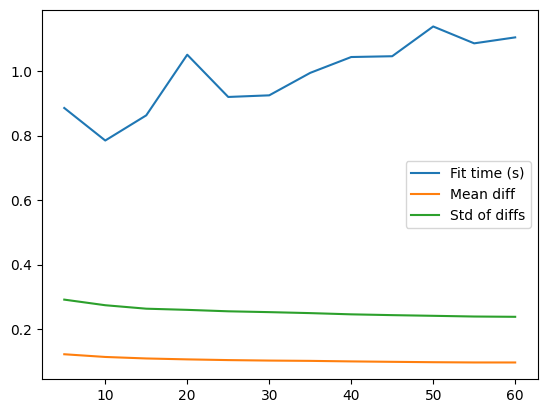

In [48]:
import matplotlib.pyplot as plt
plt.plot(num_leaves_arr, time_arr, label='Fit time (s)')
plt.plot(num_leaves_arr, mean_diff, label='Mean diff')
plt.plot(num_leaves_arr, std_diff, label='Std of diffs')
plt.legend()

<h3>XG boosted decision trees</h3>
<p style='width: 1000px;'>Apparently slower than LightGBM and less accurate.</p>
Basic parameters of interest:
<ul>    
    <li>booster
        <ul>
           <li>gbtree - most accurate</li> 
           <li>gblinear - fastest</li> 
           <li>dart - very, very slow</li> 
        </ul>
    </li>
    <li>max_leaves - set to zero and let the algorithm decide, for now</li>
</ul>

<h4>booster=gbtree</h4>

In [54]:
from xgboost.sklearn import XGBRegressor

start = time.time()
xgboost_reg = XGBRegressor(booster='gbtree', max_leaves=0, random_state=5).fit(X_train, y_train)
end = time.time()
print(f'Time to train: {end-start}s')

Time to train: 23.121641397476196s


In [55]:
y_pred = xgboost_reg.predict(X_test)
diffs = np.absolute(y_pred - y_test)
print(f'Max diff: {diffs.max()}')
print(f'Mean diff: {diffs.mean()}')
print(f'Std of diffs: {diffs.std()}')

Max diff: 15.01502807559967
Mean diff: 0.09401732871239997
Std of diffs: 0.2291665258349183


<h4>booster=gblinear</h4>

In [56]:
from xgboost.sklearn import XGBRegressor

start = time.time()
xgboost_reg2 = XGBRegressor(booster='gblinear', random_state=5).fit(X_train, y_train)
end = time.time()
print(f'Time to train: {end-start}s')

Time to train: 1.874925136566162s


In [57]:
y_pred = xgboost_reg2.predict(X_test)
diffs = np.absolute(y_pred - y_test)
print(f'Max diff: {diffs.max()}')
print(f'Mean diff: {diffs.mean()}')
print(f'Std of diffs: {diffs.std()}')

Max diff: 32.425862772464754
Mean diff: 0.2898381695553205
Std of diffs: 0.45053245706507516


<h4>booster=dart</h4>

In [59]:
from xgboost.sklearn import XGBRegressor

start = time.time()
xgboost_reg3 = XGBRegressor(booster='dart', max_leaves=0, random_state=5).fit(X_train, y_train)
end = time.time()
print(f'Time to train: {end-start}s')

Time to train: 47.74098014831543s


In [ ]:
y_pred = xgboost_reg3.predict(X_test)
diffs = np.absolute(y_pred - y_test)
print(f'Max diff: {diffs.max()}')
print(f'Mean diff: {diffs.mean()}')
print(f'Std of diffs: {diffs.std()}')

<h3>CatBoost gradient boosted decistion tree</h3>
<p>Fairly accurate, but prohibitively slow.</p>
Basic parameters of interest:
<ul>    
    <li>boosting_type
        <ul>
           <li>Plain</li> 
           <li>Ordered</li> 
        </ul>
    </li>
</ul>

<h4>boosting_type='Plain'</h4>

In [61]:
from catboost import CatBoostRegressor

start = time.time()
catboost_reg = CatBoostRegressor(boosting_type='Plain', random_state=6, silent=True).fit(X_train, y_train)
end = time.time()
print(f'Time to train: {end-start}s')

Time to train: 33.43656826019287s


In [66]:
y_pred = catboost_reg.predict(X_test)
diffs = np.absolute(y_pred - y_test)
print(f'Max diff: {diffs.max()}')
print(f'Mean diff: {diffs.mean()}')
print(f'Std of diffs: {diffs.std()}')

Max diff: 15.212767764452032
Mean diff: 0.09004299863395829
Std of diffs: 0.22607666471151516


<h4>boosting_type='Ordered'</h4>

In [63]:
from catboost import CatBoostRegressor

start = time.time()
catboost_reg2 = CatBoostRegressor(boosting_type='Ordered', random_state=6, silent=True).fit(X_train, y_train)
end = time.time()
print(f'Time to train: {end-start}s')

Time to train: 76.90928626060486s


In [65]:
y_pred = catboost_reg2.predict(X_test)
diffs = np.absolute(y_pred - y_test)
print(f'Max diff: {diffs.max()}')
print(f'Mean diff: {diffs.mean()}')
print(f'Std of diffs: {diffs.std()}')

Max diff: 14.990212580024545
Mean diff: 0.09539590402598962
Std of diffs: 0.23392284018677312


<h3>Gradient boosting regression</h3>
<p>Prohibitively slow.</p>
Basic parameters of interest:
<ul>    
    <li>loss
        <ul>
           <li>squared_error</li> 
           <li>absolute_error</li> 
            <li>huber</li>
            <li>quantile</li>
        </ul>
    </li>
</ul>

<h4>loss=squared_error</h4>

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

start = time.time()
gradboost_reg = GradientBoostingRegressor(loss='squared_error', random_state=7).fit(X_train, y_train)
end = time.time()
print(f'Time to train: {end-start}s')

Time to train: 80.61151695251465s


In [68]:
y_pred = gradboost_reg.predict(X_test)
diffs = np.absolute(y_pred - y_test)
print(f'Max diff: {diffs.max()}')
print(f'Mean diff: {diffs.mean()}')
print(f'Std of diffs: {diffs.std()}')

Max diff: 17.288022020486114
Mean diff: 0.11912327192819218
Std of diffs: 0.28292736824527065


<h4>loss=absolute_error</h4>

In [70]:
from sklearn.ensemble import GradientBoostingRegressor

start = time.time()
gradboost_reg2 = GradientBoostingRegressor(loss='absolute_error', random_state=7).fit(X_train, y_train)
end = time.time()
print(f'Time to train: {end-start}s')

Time to train: 89.55526518821716s


In [71]:
y_pred = gradboost_reg2.predict(X_test)
diffs = np.absolute(y_pred - y_test)
print(f'Max diff: {diffs.max()}')
print(f'Mean diff: {diffs.mean()}')
print(f'Std of diffs: {diffs.std()}')

Max diff: 30.793420501954806
Mean diff: 0.11521847224470702
Std of diffs: 0.35621167732191156


<h4>loss=huber</h4>

In [72]:
from sklearn.ensemble import GradientBoostingRegressor

start = time.time()
gradboost_reg3 = GradientBoostingRegressor(loss='huber', random_state=7).fit(X_train, y_train)
end = time.time()
print(f'Time to train: {end-start}s')

Time to train: 96.27127957344055s


In [74]:
y_pred = gradboost_reg3.predict(X_test)
diffs = np.absolute(y_pred - y_test)
print(f'Max diff: {diffs.max()}')
print(f'Mean diff: {diffs.mean()}')
print(f'Std of diffs: {diffs.std()}')

Max diff: 30.74090098530971
Mean diff: 0.11146256668109003
Std of diffs: 0.33630757966809355


<h4>loss=quantile</h4>

In [73]:
from sklearn.ensemble import GradientBoostingRegressor

start = time.time()
gradboost_reg4 = GradientBoostingRegressor(loss='quantile', random_state=7).fit(X_train, y_train)
end = time.time()
print(f'Time to train: {end-start}s')

Time to train: 83.73492932319641s


In [75]:
y_pred = gradboost_reg4.predict(X_test)
diffs = np.absolute(y_pred - y_test)
print(f'Max diff: {diffs.max()}')
print(f'Mean diff: {diffs.mean()}')
print(f'Std of diffs: {diffs.std()}')

Max diff: 28.5187628213218
Mean diff: 0.21616959160780597
Std of diffs: 0.3630187278509199
